## Intro to medical imaging preprocessng and augmentations: imports, packages and some images to play 

In [ ]:
!wget https://nipy.org/nibabel/_downloads/c16214e490de2a223655d30f4ba78f15/someones_anatomy.nii.gz
!wget https://nipy.org/nibabel/_downloads/f76cc5a46e5368e2c779868abc49e497/someones_epi.nii.gz
!pip install nibabel matplotlib
!ls
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import scipy
from nibabel.affines import apply_affine
np.set_printoptions(precision=3, suppress=True)
# load nifti images
epi_img = nib.load('someones_epi.nii.gz')
anatomy_img = nib.load('someones_anatomy.nii.gz')
# convert to numpy
epi_img_numpy = epi_img.get_fdata()
anatomy_img_numpy = anatomy_img.get_fdata()


## Required functions for 2D multi-plane visualization

In [ ]:
def show_mid_slice(img_numpy, title='img'):
    """
    Accepts an 3D numpy array and shows median slices in all three planes
    :param img_numpy:
    """
    assert img_numpy.ndim == 3
    n_i, n_j, n_k = img_numpy.shape

    # saggital
    center_i1 = int((n_i - 1) / 2)
    # transverse
    center_j1 = int((n_j - 1) / 2)
    # axial slice
    center_k1 = int((n_k - 1) / 2)

    show_slices([img_numpy[center_i1, :, :],
                 img_numpy[:, center_j1, :],
                 img_numpy[:, :, center_k1]])
    plt.suptitle(title)


def show_slices(slices):
    """
    Function to display a row of image slices
    Input is a list of numpy 2D image slices
    """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")


## 3D shapes and medical-header files

In [ ]:
print(epi_img_numpy.shape)
print(anatomy_img_numpy.shape)
anat_header_file = anatomy_img.header
epi_img_numpy_header = epi_img.header
print(anat_header_file)
print("\n\n\n\n\n\n")
print(epi_img_numpy_header)

(53, 61, 33)
(57, 67, 56)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 57 67 56  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.   2.75 2.75 2.75 1.   1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -78.0
qoffset_y       : -91.0
qoffset_z       : -91.0
srow_x          : [  2.75 

## Lets observe the median slices of our images first

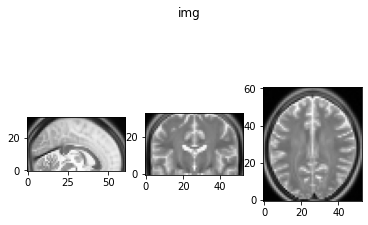

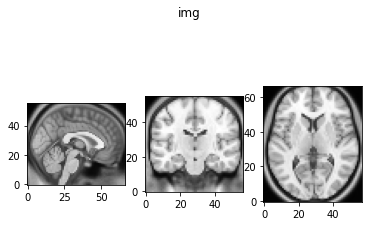

In [ ]:
show_mid_slice(epi_img_numpy)
show_mid_slice(anatomy_img_numpy)

## Tranform from one voxel space to another

We have reffered to this in a previous tutorial on image coordinate systems. For completeness, I provide it here. [Article link](https://theaisummer.com/medical-image-coordinates/)

Affine 1: [[  3.      0.      0.    -78.   ]
 [  0.      2.866  -0.887 -76.   ]
 [  0.      0.887   2.866 -64.   ]
 [  0.      0.      0.      1.   ]]
Affine 2: [[  2.75   0.     0.   -78.  ]
 [  0.     2.75   0.   -91.  ]
 [  0.     0.     2.75 -91.  ]
 [  0.     0.     0.     1.  ]]


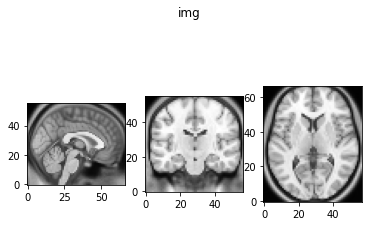

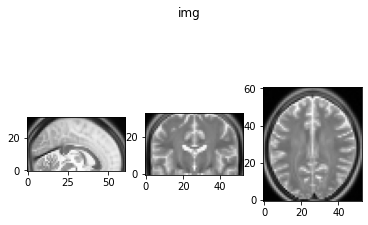

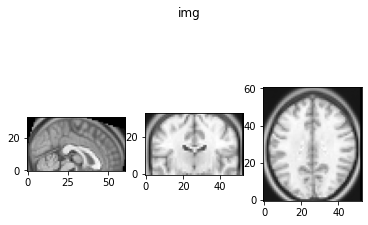

In [ ]:
import scipy
def transform_coordinate_space(modality_1, modality_2):
    """
    Transfers coordinate space from modality_2 to modality_1
    """
    aff_t1 = modality_1.affine
    aff_t2 = modality_2.affine
    print("Affine 1:", aff_t1)
    print("Affine 2:", aff_t2)
    inv_af_2 = np.linalg.inv(aff_t2)

    out_shape = modality_1.get_fdata().shape
    rgb_shape = modality_2.get_fdata().shape

    # desired transformation
    T = inv_af_2.dot(aff_t1)
    transformed = scipy.ndimage.affine_transform(modality_2.get_fdata(), T, output_shape=out_shape)
    return transformed

# transform anatomy_img to the epi_img 'world' (affine space)
transformed = transform_coordinate_space(epi_img,anatomy_img)

show_mid_slice(anatomy_img_numpy)
show_mid_slice(epi_img_numpy)
show_mid_slice(transformed)


## Spliting and unifing transformations and voxel 3d size in mm

In [ ]:
transform_A = nib.affines.from_matvec(np.diag([2, 3, 4]), [9, 10, 11])
translation_A, rotation_A = nib.affines.to_matvec(transform_A)
print('Translation: ', translation_A)
print('Rotation', rotation_A)
# Find the real size of voxels in real 3D space in mm

voxels_out = nib.affines.voxel_sizes(transform_A)
print(voxels_out)


Translation:  [[2 0 0]
 [0 3 0]
 [0 0 4]]
Rotation [ 9 10 11]
[2. 3. 4.]


## 1. Medical Image resizing

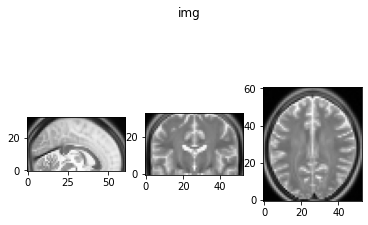

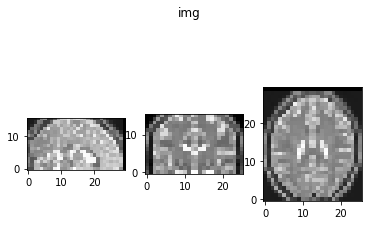

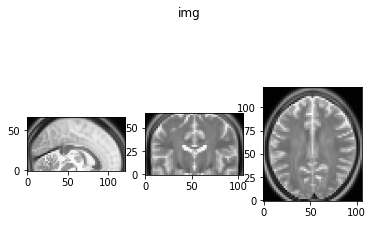

In [ ]:
import scipy
def resize_data_volume(data, dim):
    """
    Resize the data to the dim size
    """
    depth, height, width = data.shape
    scale = [dim[0] * 1.0 / depth, dim[1] * 1.0 / height, dim[2] * 1.0 / width]
    print(scale)
    return scipy.ndimage.interpolation.zoom(data, scale, order=0)

def resize_data_volume_by_scale(data, scale):
    """
    Resize the data based on the provided scale
    """
    scale_list = [scale,scale,scale]
    return scipy.ndimage.interpolation.zoom(data, scale_list, order=0)


result = resize_data_volume_by_scale(epi_img_numpy, 0.5)
result2 = resize_data_volume_by_scale(epi_img_numpy, 2)

show_mid_slice(epi_img_numpy)
show_mid_slice(result)
show_mid_slice(result2)


Note that the ratios and **not** maintained because the voxels have different size and the spatial dimensions are also different.

## 2. Medical image rescaling (zoom- in/out)

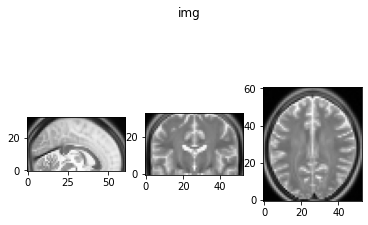

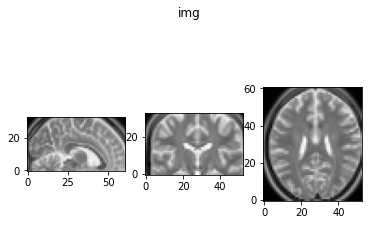

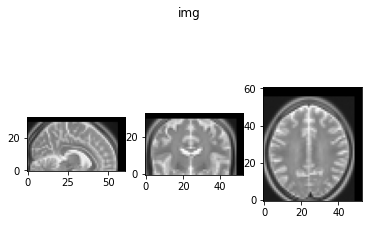

In [ ]:
def random_zoom(matrix,min_percentage=0.7, max_percentage=1.2):
    z = np.random.sample() *(max_percentage-min_percentage) + min_percentage
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.interpolation.affine_transform(matrix, zoom_matrix)



show_mid_slice((epi_img_numpy))
show_mid_slice(random_zoom(epi_img_numpy))
show_mid_slice(random_zoom(epi_img_numpy))

## 3. 3D medical image rotation

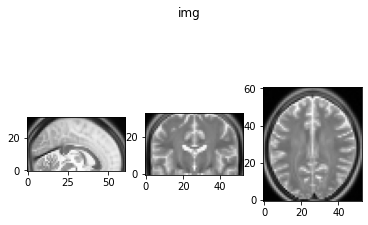

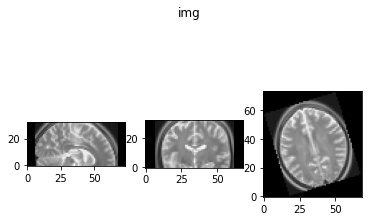

In [ ]:
import scipy.ndimage as ndimage
def random_rotate3D(img_numpy, min_angle, max_angle):
    """
    Returns a random rotated array in the same shape
    :param img_numpy: 3D numpy array
    :param min_angle: in degrees
    :param max_angle: in degrees
    :return:
    """
    assert img_numpy.ndim == 3, "provide a 3d numpy array"
    assert min_angle < max_angle, "min should be less than max val"
    assert min_angle > -360 or max_angle < 360
    all_axes = [(1, 0), (1, 2), (0, 2)]
    angle = np.random.randint(low=min_angle, high=max_angle+1)
    axes_random_id = np.random.randint(low=0, high=len(all_axes))
    axes = all_axes[axes_random_id]

    return scipy.ndimage.rotate(img_numpy, angle, axes=axes)
  
  
show_mid_slice(epi_img_numpy)
show_mid_slice(random_rotate3D(epi_img_numpy,-20,20))








## 4. 3D medical image flip

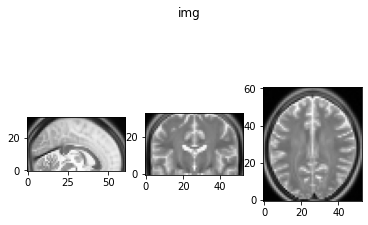

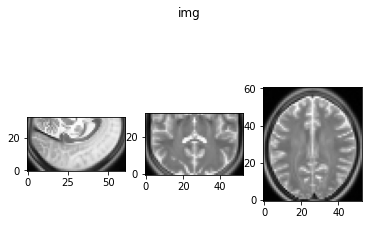

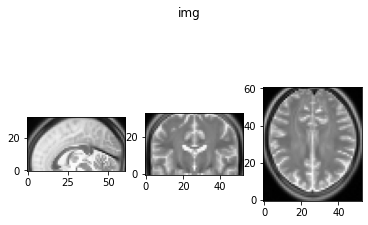

In [ ]:
def random_flip(img, label=None):
    axes = [0, 1, 2]
    rand = np.random.randint(0, 3)
    img = flip_axis(img, axes[rand])
    img = np.squeeze(img)

    if label is None:
      return img
    else:
      y = flip_axis(y, axes[rand])
      y = np.squeeze(y)
    return x, y

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


show_mid_slice((epi_img_numpy))
show_mid_slice(random_flip(epi_img_numpy))
show_mid_slice(random_flip(epi_img_numpy))


## 5. Medical image shifting (displacement)


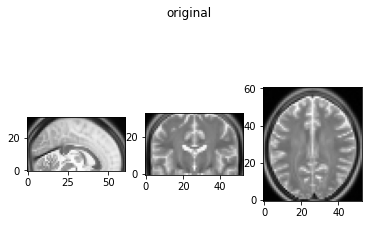

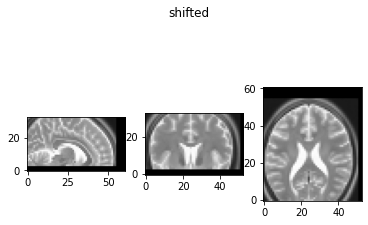

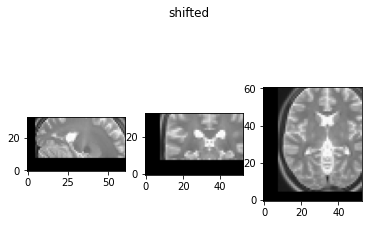

In [ ]:
def transform_matrix_offset_center_3d(matrix, x, y, z):
    offset_matrix = np.array([[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]])
    return ndimage.interpolation.affine_transform(matrix, offset_matrix)

def random_shift(img_numpy, max_percentage=0.4):
  dim1, dim2, dim3 = img_numpy.shape
  m1,m2,m3 = int(dim1*max_percentage/2),int(dim1*max_percentage/2), int(dim1*max_percentage/2)
  d1 = np.random.randint(-m1,m1)
  d2 = np.random.randint(-m2,m2)
  d3 = np.random.randint(-m3,m3)
  return transform_matrix_offset_center_3d(img_numpy, d1, d2, d3)
  

show_mid_slice((epi_img_numpy), 'original')
show_mid_slice(random_shift(epi_img_numpy),'shifted')
show_mid_slice(random_shift(epi_img_numpy),'shifted')


## Clip intensity values (outliers)

---



In [ ]:
def clip_range(img_numpy):
    """
    Cut off outliers that are related to detected black in the image (the air area)
    """
    zero_value = (img_numpy[0, 0, 0] + img_numpy[-1, 0, 0] + img_numpy[0, -1, 0] + \
                  img_numpy[0, 0, -1] + img_numpy[-1, -1, -1] + img_numpy[-1, -1, 0] \
                  + img_numpy[0, -1, -1] + img_numpy[-1, 0, -1]) / 8.0
    non_zeros_idx = np.where(img_numpy >= zero_value)
    [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
    [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)
    y = img_numpy[min_z:max_z, min_h:max_h, min_w:max_w]
    return y


def percentile_clip(img_numpy, min_val=5, max_val=95):
    """
    Intensity normalization based on percentile
    Clips the range based on the quarile values.
    :param min_val: should be in the range [0,100]
    :param max_val: should be in the range [0,100]
    :return: intesity normalized image
    """
    low = np.percentile(img_numpy, min_val)
    high = np.percentile(img_numpy, max_val)

    img_numpy[img_numpy < low] = low
    img_numpy[img_numpy > high] = high
    return img_numpy


show_mid_slice((anatomy_img_numpy))
show_mid_slice(clip_range(anatomy_img_numpy))
show_mid_slice(percentile_clip(anatomy_img_numpy))
print(anatomy_img_numpy.min(),anatomy_img_numpy.max())
print(clip_range(anatomy_img_numpy).min(),clip_range(anatomy_img_numpy).max())
print(percentile_clip(anatomy_img_numpy).min(),percentile_clip(anatomy_img_numpy).max())

##  3D medical image crop

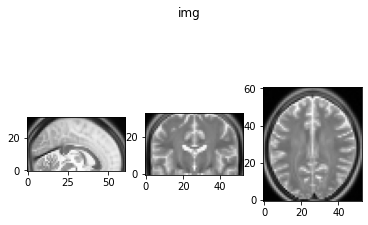

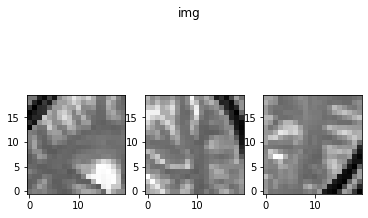

In [ ]:
def crop_3d_volume(img_tensor, crop_dim, crop_size):
    assert img_tensor.ndim == 3, '3d tensor must be provided'
    full_dim1, full_dim2, full_dim3 = img_tensor.shape
    slices_crop, w_crop, h_crop = crop_dim
    dim1, dim2, dim3 = crop_size

    # check if crop size matches image dimensions
    if full_dim1 == dim1:
        img_tensor = img_tensor[:, w_crop:w_crop + dim2,
                     h_crop:h_crop + dim3]
    elif full_dim2 == dim2:
        img_tensor = img_tensor[slices_crop:slices_crop + dim1, :,
                     h_crop:h_crop + dim3]
    elif full_dim3 == dim3:
        img_tensor = img_tensor[slices_crop:slices_crop + dim1, w_crop:w_crop + dim2, :]
    # standard crop
    else:
        img_tensor = img_tensor[slices_crop:slices_crop + dim1, w_crop:w_crop + dim2,
                     h_crop:h_crop + dim3]
    return img_tensor

def find_random_crop_dim(full_vol_dim, crop_size):
    assert full_vol_dim[0] >= crop_size[0], "crop size is too big"
    assert full_vol_dim[1] >= crop_size[1], "crop size is too big"
    assert full_vol_dim[2] >= crop_size[2], "crop size is too big"

    if full_vol_dim[0] == crop_size[0]:
        slices = crop_size[0]
    else:
        slices = np.random.randint(full_vol_dim[0] - crop_size[0])

    if full_vol_dim[1] == crop_size[1]:
        w_crop = crop_size[1]
    else:
        w_crop = np.random.randint(full_vol_dim[1] - crop_size[1])

    if full_vol_dim[2] == crop_size[2]:
        h_crop = crop_size[2]
    else:
        h_crop = np.random.randint(full_vol_dim[2] - crop_size[2])

    return (slices, w_crop, h_crop)

crop_size = (20,20,20)
crop_dim = find_random_crop_dim(epi_img_numpy.shape, crop_size)
croped_img_numpy = crop_3d_volume(epi_img_numpy, crop_dim, crop_size)

show_mid_slice((epi_img_numpy))
show_mid_slice(croped_img_numpy)

  

## Intensity normalization

In [ ]:
def normalize_intensity(img_tensor, normalization="mean"):
    """
    Accepts an image tensor and normalizes it
    :param normalization: choices = "max", "mean" , type=str
    For mean normalization we use the non zero voxels only.
    """ 
    if normalization == "mean":
        mask = img_tensor.ne(0.0)
        desired = img_tensor[mask]
        mean_val, std_val = desired.mean(), desired.std()
        img_tensor = (img_tensor - mean_val) / std_val
    elif normalization == "max":
      MAX, MIN = img_tensor.max(), img_tensor.min()
      img_tensor = (img_tensor - MIN) / (MAX - MIN)
    return img_tensor


## Elastic deformation 3D

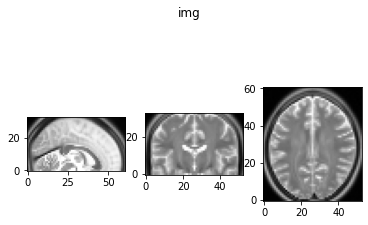

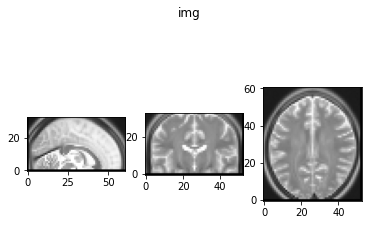

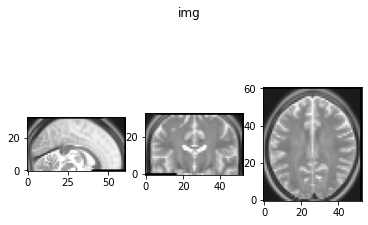

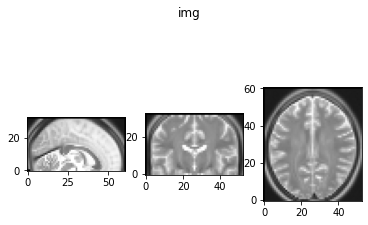

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import gaussian_filter

def elastic_transform_3d(image, labels=None, alpha=6, sigma=40, bg_val=0.1):
    """
    Elastic deformation of images as described in 
    Simard, Steinkraus and Platt, "Best Practices for
    Convolutional Neural Networks applied to Visual 
    Document Analysis", in
    Proc. of the International Conference on Document Analysis and
    Recognition, 2003.

    Modified from:
    https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    https://github.com/fcalvet/image_tools/blob/master/image_augmentation.py#L62

    Modified to take 3D inputs
    Deforms both the image and corresponding label file
    image linear/trilinear interpolated
    Label volumes nearest neighbour interpolated
    """
    assert image.ndim == 3
    shape = image.shape
    dtype = image.dtype

    # Define coordinate system
    coords = np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2])

    # Initialize interpolators
    im_intrps = RegularGridInterpolator(coords, image,
                                                 method="linear",
                                                 bounds_error=False,
                                                 fill_value=bg_val)

    # Get random elastic deformations
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dz = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha

    # Define sample points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]
    indices = np.reshape(x + dx, (-1, 1)), \
              np.reshape(y + dy, (-1, 1)), \
              np.reshape(z + dz, (-1, 1))

    # Interpolate 3D image image
    image = np.empty(shape=image.shape, dtype=dtype)
    image = im_intrps(indices).reshape(shape)

    # Interpolate labels
    if labels is not None:
        lab_intrp = RegularGridInterpolator(coords, labels,
                                            method="nearest",
                                            bounds_error=False,
                                            fill_value=0)

        labels = lab_intrp(indices).reshape(shape).astype(labels.dtype)
        return image, labels

    
    return image


show_mid_slice((epi_img_numpy))
show_mid_slice(elastic_transform_3d(epi_img_numpy))
show_mid_slice(elastic_transform_3d(epi_img_numpy))
show_mid_slice(elastic_transform_3d(epi_img_numpy))